#ANÁLISE DE REVIEWS DE JOGOS DA STEAM

###DESCRIÇÃO DO PROJETO

Conjunto de dados: Reviews do Steam.

O conjunto de dados pode ser encontrado no seguinte link: https://www.kaggle.com/datasets/yukawithdata/steam-review-stats-dataset.

Este projeto conterá os seguintes três tópicos apresentados na disciplina:

*  Sumarização de texto: resume os reviews, de forma a preservar as partes mais relevantes, tornando o processamento seguinte mais rápido.
*  Análise de sentimento: analisa o sentimento dos reviews gerados pelos usuários.
*  Modelagem de Tópicos: busca colher feedback dos usuários por meio de seus reviews, tentando identificar tendências.



In [2]:
#Importando o arquivo do google drive
import requests
import zipfile
from io import BytesIO

# ID do arquivo zip no Google Drive. O zip foi baixado do site mencionado acima. Não conta com nenhum tratamento, o que irá ocorrer ao longo deste código.
#O link original de compartilhamento do zip é https://drive.google.com/file/d/1Ei9jO0kK1oPFO_-TASB4bIsJNRC6HTKQ/view?usp=share_link
file_id = "1Ei9jO0kK1oPFO_-TASB4bIsJNRC6HTKQ"

# URL de download do arquivo zip.
url = f"https://drive.google.com/uc?id={file_id}&export=download"

# Faz o download do arquivo zip.
response = requests.get(url)
file_bytes = BytesIO(response.content)

# Extrai o arquivo zip.
with zipfile.ZipFile(file_bytes, "r") as zip_ref:
    zip_ref.extractall()

Utilização do pandas para leitura do .csv que contém a base de dados acima. O documento é intitulado *tableau_steam.csv*.

In [3]:
import pandas as pd

# Lê o arquivo csv da base de dados extraída acima. Imprime-a para que verifiquemos seu conteúdo.
df = pd.read_csv('/content/tableau_steam.csv')

df

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,title,ave_sentiment,word_count,new_review
0,2017-06-20,85,2139,612,False,Recommended,Dead by Daylight,-0.091786,260,Disclaimer I survivor main I play for fun not...
1,2018-12-24,295,219,71,False,Recommended,Dead by Daylight,0.041603,13,I have never been told to kill myself more tha...
2,2018-12-05,380,271,414,False,Recommended,Dead by Daylight,-0.166667,9,if you think cs go is toxic try this
3,2018-12-04,11,106,900,False,Recommended,Dead by Daylight,-0.215483,290,This is simultaneously the most fun and most i...
4,2018-01-16,88,614,1878,False,Recommended,Dead by Daylight,-0.019964,310,Kids Everyone Casual players Pro players Graph...
...,...,...,...,...,...,...,...,...,...,...
260901,2018-11-15,2,110,44,False,Recommended,"Warhammer 40,000: Mechanicus",0.769526,954,Mechanicus is a that shares a few similaritie...
260902,2018-11-17,1,37,10,False,Recommended,"Warhammer 40,000: Mechanicus",0.437147,327,YOUR FLESH WILL ROT AND DECAYSTEEL IS IMMORTAL...
260903,2018-11-20,0,0,36,False,Recommended,"Warhammer 40,000: Mechanicus",0.353553,128,First off if you like X Com style of you will...
260904,2018-11-18,1,44,12,False,Recommended,"Warhammer 40,000: Mechanicus",0.630964,328,As a disclaimer Im an AdMech player on the tab...


#PRÉ-PROCESSAMENTO DE DADOS

Neste pré-processamento, realizaremos algumas etapas importantes que tornarão as implementações futuras mais eficientes (e possíveis):

* Remoção de reviews vazios.
* Conversão de todo o texto para letras minúsculas.
* Remoção de caracteres especiais e possíveis pontuações.
* Tokenização
* Remoção de stopwords

In [4]:
# Agrupando o dataframe pelo título do jogo e contando o número de reviews para cada jogo.
review_count = df.groupby('title')['date_posted'].count()

# Criando um novo dataframe apenas com os jogos que possuem 100 ou mais reviews.
df_filtered = df[df['title'].isin(review_count[review_count >= 100].index)]

df = df_filtered


# Verificando valores nulos.
df.isnull().sum()

date_posted                  0
funny                        0
helpful                      0
hour_played                  0
is_early_access_review       0
recommendation               0
title                        0
ave_sentiment                0
word_count                   0
new_review                3184
dtype: int64

In [5]:
# Remove os valores nulos/vazios.
df= df.dropna()
df = df.reset_index(drop=True)

df.isnull().sum()

date_posted               0
funny                     0
helpful                   0
hour_played               0
is_early_access_review    0
recommendation            0
title                     0
ave_sentiment             0
word_count                0
new_review                0
dtype: int64

In [6]:
# Lista de contractions do inglês, para que tratemos melhor o texto. Essa lista pode ser encontrada em http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

# Função para substituir palavras contraídas presentes nos reviews por sua versão não contraída.
def replace_contractions(text):
    for key, value in contractions.items():
        text = text.replace(key, value)
    return text

# Cria uma nova coluna, removendo as contrações. Usaremos essa coluna para limpar o texto posteriormente.
df['clean_review'] = df['new_review'].apply(replace_contractions)

In [7]:
# Importando as bibliotecas necessárias

import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:
# Função para remover números da string.
def remove_numbers(text):
    result = ''.join([i for i in text if not i.isdigit()])
    return result

# Aplicando a função na coluna 'new_review'.
df['clean_review'] = df['clean_review'].apply(remove_numbers)

# Converte todos os reviews para letras minúsculas.
df['clean_review'] = df['clean_review'].apply(lambda x: x.lower())

# Remoção de pontuação.
df['clean_review'] = df['clean_review'].apply(lambda x: re.sub('[^\w\s]','',x))

# Tokenização.
df['clean_review'] = df['clean_review'].apply(lambda x: word_tokenize(x))

# Remoção de stop words.
stop_words = set(stopwords.words('english'))
df['clean_review'] = df['clean_review'].apply(lambda x: [word for word in x if word not in stop_words])


# Forma novamente o texto.
df['text_review'] = df['clean_review'].apply(lambda x: ' '.join(x))

df

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,title,ave_sentiment,word_count,new_review,clean_review,text_review
0,2017-06-20,85,2139,612,False,Recommended,Dead by Daylight,-0.091786,260,Disclaimer I survivor main I play for fun not...,"[disclaimer, survivor, main, play, fun, compet...",disclaimer survivor main play fun competition ...
1,2018-12-24,295,219,71,False,Recommended,Dead by Daylight,0.041603,13,I have never been told to kill myself more tha...,"[never, told, kill, playing]",never told kill playing
2,2018-12-05,380,271,414,False,Recommended,Dead by Daylight,-0.166667,9,if you think cs go is toxic try this,"[think, cs, go, toxic, try]",think cs go toxic try
3,2018-12-04,11,106,900,False,Recommended,Dead by Daylight,-0.215483,290,This is simultaneously the most fun and most i...,"[simultaneously, fun, infuriating, ive, played...",simultaneously fun infuriating ive played long...
4,2018-01-16,88,614,1878,False,Recommended,Dead by Daylight,-0.019964,310,Kids Everyone Casual players Pro players Graph...,"[kids, everyone, casual, players, pro, players...",kids everyone casual players pro players graph...
...,...,...,...,...,...,...,...,...,...,...,...,...
257405,2019-02-06,0,0,10,False,Recommended,Human: Fall Flat,-1.613625,7,Good but I wish for more content,"[good, wish, content]",good wish content
257406,2019-02-06,0,0,5,False,Recommended,Human: Fall Flat,0.540929,24,Goofy blobs with a knack for puzzle solving is...,"[goofy, blobs, knack, puzzle, solving, great, ...",goofy blobs knack puzzle solving great way spe...
257407,2019-02-07,0,0,23,False,Recommended,Human: Fall Flat,-0.359670,22,great although my its annoying when your frie...,"[great, although, annoying, friends, grab, gro...",great although annoying friends grab ground wo...
257408,2019-02-07,0,0,8,False,Recommended,Human: Fall Flat,0.883883,2,Amazingly fun,"[amazingly, fun]",amazingly fun


In [9]:
# Substituamos os valores não numéricos por numéricos. Além disso, como não haverá análise entre review e data de postagem, removamos a coluna de data.

# Substituição dos valores booleanos por 1 e 0
df['is_early_access_review'] = df['is_early_access_review'].map({True: 1, False: 0})
df['recommendation'] = df['recommendation'].map({'Recommended': 1, 'Not Recommended': 0})

df

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,title,ave_sentiment,word_count,new_review,clean_review,text_review
0,2017-06-20,85,2139,612,0,1,Dead by Daylight,-0.091786,260,Disclaimer I survivor main I play for fun not...,"[disclaimer, survivor, main, play, fun, compet...",disclaimer survivor main play fun competition ...
1,2018-12-24,295,219,71,0,1,Dead by Daylight,0.041603,13,I have never been told to kill myself more tha...,"[never, told, kill, playing]",never told kill playing
2,2018-12-05,380,271,414,0,1,Dead by Daylight,-0.166667,9,if you think cs go is toxic try this,"[think, cs, go, toxic, try]",think cs go toxic try
3,2018-12-04,11,106,900,0,1,Dead by Daylight,-0.215483,290,This is simultaneously the most fun and most i...,"[simultaneously, fun, infuriating, ive, played...",simultaneously fun infuriating ive played long...
4,2018-01-16,88,614,1878,0,1,Dead by Daylight,-0.019964,310,Kids Everyone Casual players Pro players Graph...,"[kids, everyone, casual, players, pro, players...",kids everyone casual players pro players graph...
...,...,...,...,...,...,...,...,...,...,...,...,...
257405,2019-02-06,0,0,10,0,1,Human: Fall Flat,-1.613625,7,Good but I wish for more content,"[good, wish, content]",good wish content
257406,2019-02-06,0,0,5,0,1,Human: Fall Flat,0.540929,24,Goofy blobs with a knack for puzzle solving is...,"[goofy, blobs, knack, puzzle, solving, great, ...",goofy blobs knack puzzle solving great way spe...
257407,2019-02-07,0,0,23,0,1,Human: Fall Flat,-0.359670,22,great although my its annoying when your frie...,"[great, although, annoying, friends, grab, gro...",great although annoying friends grab ground wo...
257408,2019-02-07,0,0,8,0,1,Human: Fall Flat,0.883883,2,Amazingly fun,"[amazingly, fun]",amazingly fun


# Sumarização de texto

Nesta etapa, façamos uma sumarização dos reviews. Sumarizá-los tornará as etapas posteriores mais rápidas e eficientes.

Como o objetivo é resumir um review de jogo, a sumarização extrativa será mais adequada, pois extrairemos as informações relevantes de forma a condensá-las em uma informação sucinta que será utilizada na posterior análise de sentimento.

In [10]:
import nltk
from nltk.tokenize import sent_tokenize
from nltk.probability import FreqDist
from heapq import nlargest

nltk.download('punkt')

# função para realizar a sumarização
def summarize_text(text, n):
    sentences = sent_tokenize(text)
    word_frequencies = FreqDist(sentences)
    most_frequent_sentences = nlargest(n, word_frequencies, key=word_frequencies.get)
    summary = ' '.join(most_frequent_sentences)
    return summary

# exemplo de uso da função de sumarização para obter um resumo dos 3 principais tópicos dos textos da coluna "text_review"
n = 3
df['summary'] = df['text_review'].apply(lambda x: summarize_text(x, n))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
# Imprime n exemplos de textos sumarizados, mostrando o texto não sumarizado da coluna 'new_review' e a sumarização da coluna 'summary'.
def print_review_summary(df, n=5):
    for i, row in df.sample(n).iterrows():
        print(f"Review: {row['new_review']}")
        print(f"Summary: {row['summary']}\n")

print('Exemplos de reviews e seu respectivo resumo:\n')
print_review_summary(df, 10)

Exemplos de reviews e seu respectivo resumo:

Review: I do not recommend anyone to buy this  Take Two Interactives actions are the reason whyThe final straw was their decision to take down OpenIVStay away from this product it isnt worth your money
Summary: recommend anyone buy take two interactives actions reason whythe final straw decision take openivstay away product isnt worth money

Review: This  is ing awsome Good job Rockstar North 
Summary: ing awsome good job rockstar north

Review: Los Pceros no nos andamos con mamadas la serie Grand theft Auto es una de las que mas he disfrutado en mi vida como video jugadorEsa Mamada de Censurar los mods solo ha provocoado la ira de quienes ya terminamos el juego y queremos seguir jugandolo con nuevas opciones graficas Take Two pudreteNingun juego de estos nastardos hasta que se retracten de sus puterias
Summary: los pceros nos andamos con mamadas la serie grand theft auto es una de las que mas disfrutado en mi vida como video jugadoresa mam

Façamos agora algumas estatísticas a respeito da sumarização realizada.

In [12]:
# Calcula a quantidade de palavras dos textos originais.
df["word_count_review"] = df["new_review"].apply(lambda x: len(x.split()))

# Calcula a quantidade de palavras dos textos sumarizados.
df["word_count_summary"] = df["summary"].apply(lambda x: len(x.split()))

# Calcula a média de palavras dos textos originais.
mean_word_count_review = df["word_count_review"].mean()

# Calcula a média de palavras dos textos sumarizados.
mean_word_count_summary = df["word_count_summary"].mean()

# Calcula a diferença percentual entre a quantidade de palavras dos textos originais e dos textos sumarizados.
diff_percent = 100 * (mean_word_count_review - mean_word_count_summary) / mean_word_count_review

# Imprime as estatísticas.
print("Média de palavras dos textos originais:", mean_word_count_review)
print("Média de palavras dos textos sumarizados:", mean_word_count_summary)
print("Diferença percentual:", diff_percent)

Média de palavras dos textos originais: 38.84116390194631
Média de palavras dos textos sumarizados: 20.446754205353326
Diferença percentual: 47.35802908231401


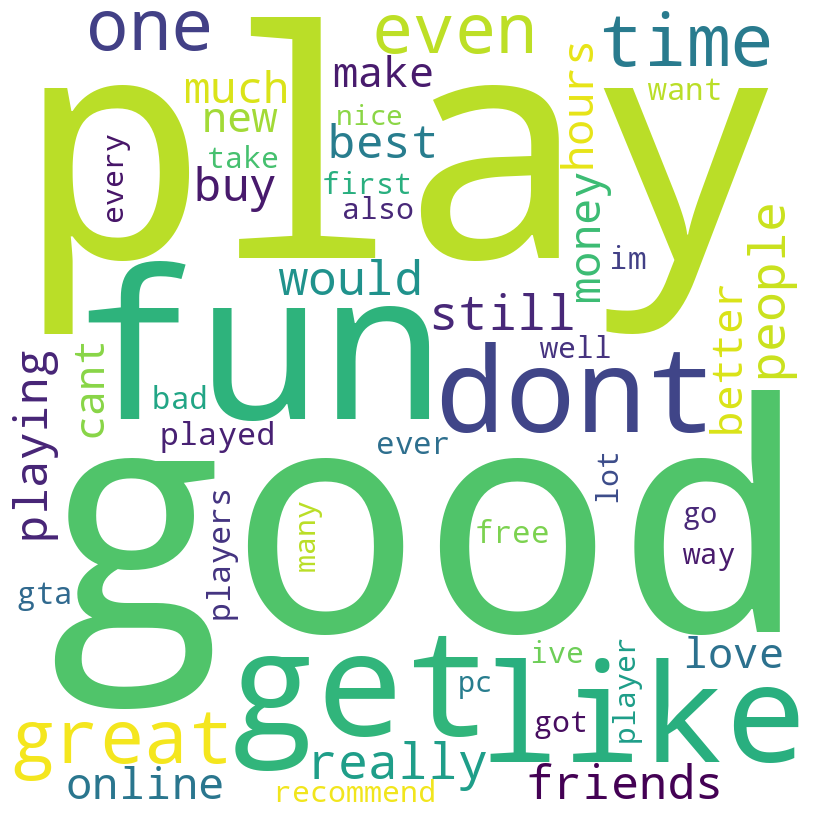

In [13]:
# Wordcloud para as palavras mais comuns.
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Juntando todas as sumarizações em uma única string.
all_summaries = ' '.join(df['summary'])

# Contando a frequência das palavras.
word_counts = Counter(all_summaries.split())

# Gerando a wordcloud com as 50 palavras mais comuns.
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', 
                min_font_size = 10, max_words=50).generate_from_frequencies(word_counts)

# Plotando a wordcloud.
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# Análise de sentimento

Façamos, a partir dos reviews sumarizados, uma análise de sentimento usando textblob.

In [14]:
from textblob import TextBlob

# Criando uma nova coluna 'sentiment' com o sentimento de cada review.
df['sentiment'] = df['summary'].apply(lambda x: TextBlob(x).sentiment.polarity)

df

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,title,ave_sentiment,word_count,new_review,clean_review,text_review,summary,word_count_review,word_count_summary,sentiment
0,2017-06-20,85,2139,612,0,1,Dead by Daylight,-0.091786,260,Disclaimer I survivor main I play for fun not...,"[disclaimer, survivor, main, play, fun, compet...",disclaimer survivor main play fun competition ...,disclaimer survivor main play fun competition ...,260,131,0.035321
1,2018-12-24,295,219,71,0,1,Dead by Daylight,0.041603,13,I have never been told to kill myself more tha...,"[never, told, kill, playing]",never told kill playing,never told kill playing,13,4,0.000000
2,2018-12-05,380,271,414,0,1,Dead by Daylight,-0.166667,9,if you think cs go is toxic try this,"[think, cs, go, toxic, try]",think cs go toxic try,think cs go toxic try,9,5,0.000000
3,2018-12-04,11,106,900,0,1,Dead by Daylight,-0.215483,290,This is simultaneously the most fun and most i...,"[simultaneously, fun, infuriating, ive, played...",simultaneously fun infuriating ive played long...,simultaneously fun infuriating ive played long...,290,162,-0.012574
4,2018-01-16,88,614,1878,0,1,Dead by Daylight,-0.019964,310,Kids Everyone Casual players Pro players Graph...,"[kids, everyone, casual, players, pro, players...",kids everyone casual players pro players graph...,kids everyone casual players pro players graph...,310,185,0.120817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257405,2019-02-06,0,0,10,0,1,Human: Fall Flat,-1.613625,7,Good but I wish for more content,"[good, wish, content]",good wish content,good wish content,7,3,0.700000
257406,2019-02-06,0,0,5,0,1,Human: Fall Flat,0.540929,24,Goofy blobs with a knack for puzzle solving is...,"[goofy, blobs, knack, puzzle, solving, great, ...",goofy blobs knack puzzle solving great way spe...,goofy blobs knack puzzle solving great way spe...,24,13,0.275000
257407,2019-02-07,0,0,23,0,1,Human: Fall Flat,-0.359670,22,great although my its annoying when your frie...,"[great, although, annoying, friends, grab, gro...",great although annoying friends grab ground wo...,great although annoying friends grab ground wo...,22,11,0.000000
257408,2019-02-07,0,0,8,0,1,Human: Fall Flat,0.883883,2,Amazingly fun,"[amazingly, fun]",amazingly fun,amazingly fun,2,2,0.300000


In [15]:
# Definindo os limites para as categorias de sentimento.
positive_lim = 0.1 #acima de 0.1 o sentimento é positivo
negative_lim = -0.1 #abaixo de -0.1 é negativo
# Caso esteja entre os dois limites, o sentimento será neutro.

# Criando uma nova coluna 'sentiment_category' com as categorias de sentimento.
df['sentiment_category'] = df['sentiment'].apply(lambda x: 'Positive' if x >= positive_lim else ('Negative' if x <= negative_lim else 'Neutral'))

df

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,title,ave_sentiment,word_count,new_review,clean_review,text_review,summary,word_count_review,word_count_summary,sentiment,sentiment_category
0,2017-06-20,85,2139,612,0,1,Dead by Daylight,-0.091786,260,Disclaimer I survivor main I play for fun not...,"[disclaimer, survivor, main, play, fun, compet...",disclaimer survivor main play fun competition ...,disclaimer survivor main play fun competition ...,260,131,0.035321,Neutral
1,2018-12-24,295,219,71,0,1,Dead by Daylight,0.041603,13,I have never been told to kill myself more tha...,"[never, told, kill, playing]",never told kill playing,never told kill playing,13,4,0.000000,Neutral
2,2018-12-05,380,271,414,0,1,Dead by Daylight,-0.166667,9,if you think cs go is toxic try this,"[think, cs, go, toxic, try]",think cs go toxic try,think cs go toxic try,9,5,0.000000,Neutral
3,2018-12-04,11,106,900,0,1,Dead by Daylight,-0.215483,290,This is simultaneously the most fun and most i...,"[simultaneously, fun, infuriating, ive, played...",simultaneously fun infuriating ive played long...,simultaneously fun infuriating ive played long...,290,162,-0.012574,Neutral
4,2018-01-16,88,614,1878,0,1,Dead by Daylight,-0.019964,310,Kids Everyone Casual players Pro players Graph...,"[kids, everyone, casual, players, pro, players...",kids everyone casual players pro players graph...,kids everyone casual players pro players graph...,310,185,0.120817,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257405,2019-02-06,0,0,10,0,1,Human: Fall Flat,-1.613625,7,Good but I wish for more content,"[good, wish, content]",good wish content,good wish content,7,3,0.700000,Positive
257406,2019-02-06,0,0,5,0,1,Human: Fall Flat,0.540929,24,Goofy blobs with a knack for puzzle solving is...,"[goofy, blobs, knack, puzzle, solving, great, ...",goofy blobs knack puzzle solving great way spe...,goofy blobs knack puzzle solving great way spe...,24,13,0.275000,Positive
257407,2019-02-07,0,0,23,0,1,Human: Fall Flat,-0.359670,22,great although my its annoying when your frie...,"[great, although, annoying, friends, grab, gro...",great although annoying friends grab ground wo...,great although annoying friends grab ground wo...,22,11,0.000000,Neutral
257408,2019-02-07,0,0,8,0,1,Human: Fall Flat,0.883883,2,Amazingly fun,"[amazingly, fun]",amazingly fun,amazingly fun,2,2,0.300000,Positive


Tendo a análise de sentimento sido feita para cada review, façamos agora uma busca pelos 5 jogos que mais geraram sentimento positivo e os 5 que mais geraram sentimento negativo.

In [16]:
# Selecionando os 5 jogos com sentimento mais positivo.
positive_reviews = df[['title', 'sentiment']].groupby('title').mean().sort_values('sentiment', ascending=False).head(5)

# Selecionando os 5 jogos com sentimento mais negativo.
negative_reviews = df[['title', 'sentiment']].groupby('title').mean().sort_values('sentiment', ascending=True).head(5)

# Imprimindo os resultados.
print('Os 5 jogos com sentimentos mais positivos:')
print(positive_reviews)

print('\nOs 5 jogos com sentimentos mais negativos:')
print(negative_reviews)

Os 5 jogos com sentimentos mais positivos:
                        sentiment
title                            
Left 4 Dead 2            0.334079
Euro Truck Simulator 2   0.332831
Insurgency: Sandstorm    0.329425
Slay the Spire           0.321238
Don't Starve Together    0.306183

Os 5 jogos com sentimentos mais negativos:
                               sentiment
title                                   
ARK: Survival Evolved           0.073453
PLAYERUNKNOWN'S BATTLEGROUNDS   0.192202
Sid Meier’s Civilization® VI    0.193905
MONSTER HUNTER: WORLD           0.211722
Grand Theft Auto V              0.214068


In [17]:
#Função para gerar wordclouds.

def create_wordcloud(reviews, title):
    text = ' '.join(reviews)
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(text)
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title)
    plt.show()

Wordclouds para os reviews mais positivos e mais negativos.

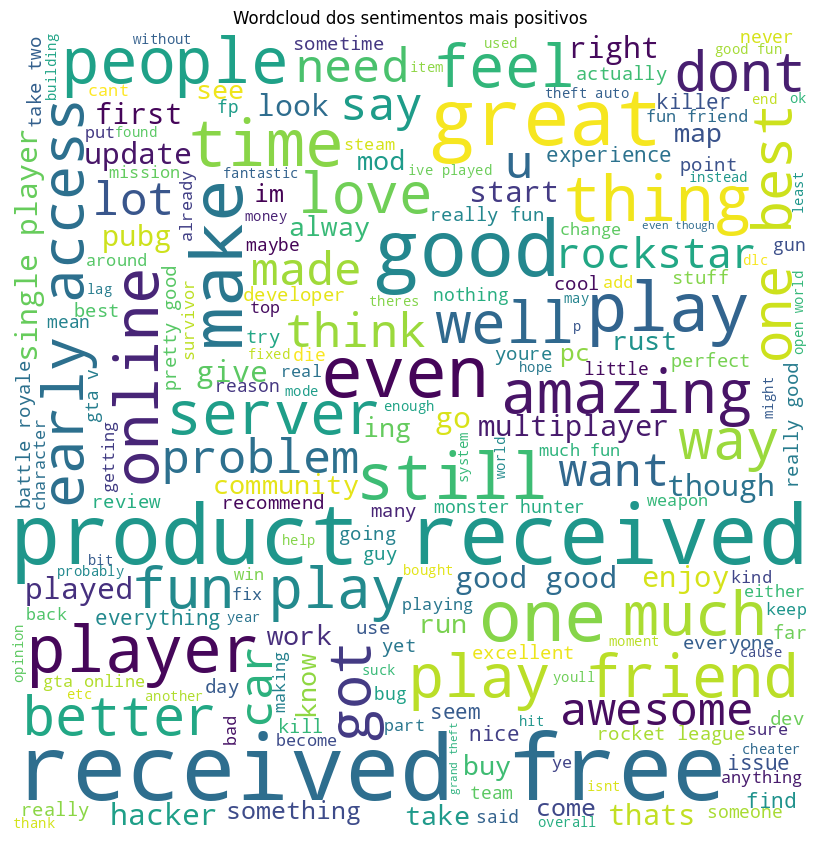

In [18]:
# wordcloud dos sentimentos mais positivos.
positive_reviews = df[df['sentiment_category'] == 'Positive']['summary'].tolist()
create_wordcloud(positive_reviews, "Wordcloud dos sentimentos mais positivos")

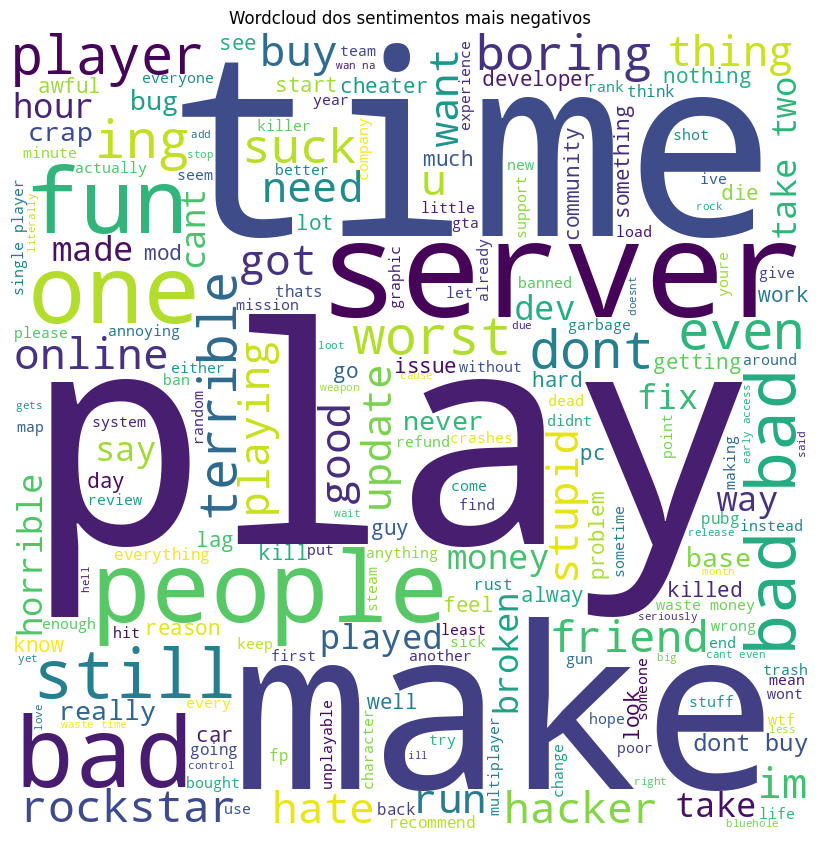

In [19]:
# wordcloud dos sentimentos mais negativos.
negative_reviews = df[df['sentiment_category'] == 'Negative']['summary'].tolist()
create_wordcloud(negative_reviews, "Wordcloud dos sentimentos mais negativos")

Wordcloud que mostra os jogos que geram mais sentimentos positivos e negativos.

In [20]:
positive_counts = df[df['sentiment_category'] == 'Positive'].groupby('title')['title'].count()
negative_counts = df[df['sentiment_category'] == 'Negative'].groupby('title')['title'].count()

df_pos = pd.DataFrame({'title': positive_counts.index, 'count': positive_counts.values})
df_neg = pd.DataFrame({'title': negative_counts.index, 'count': negative_counts.values})

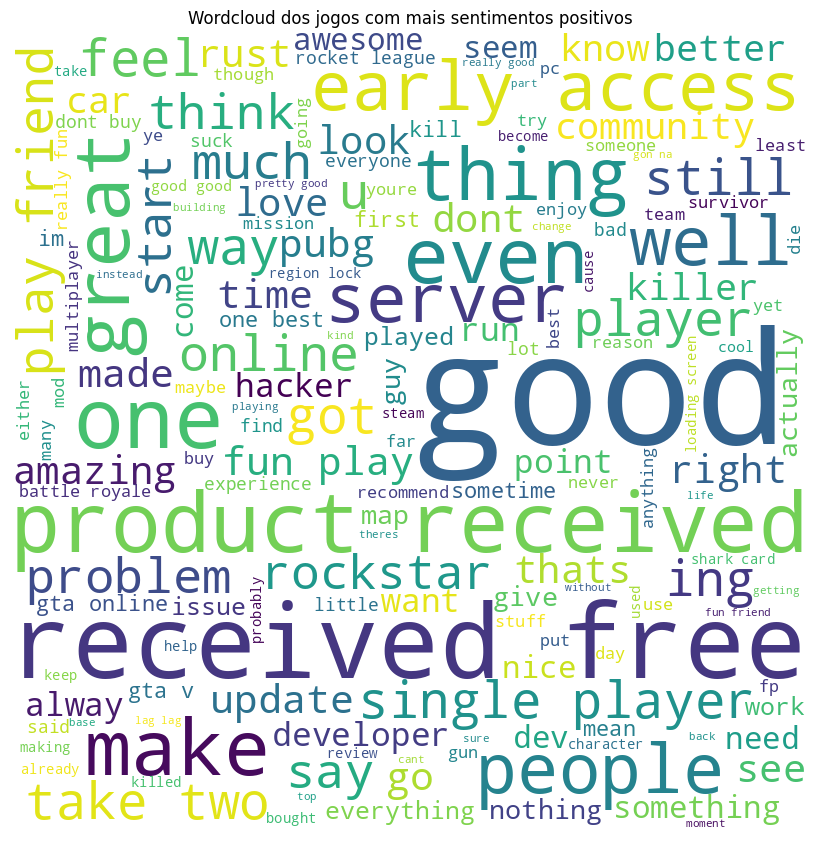

In [21]:
# wordcloud dos jogos com mais sentimentos positivos.
top_pos = df_pos.nlargest(5, 'count')
positive_games = top_pos['title'].tolist()
positive_reviews = df[df['title'].isin(positive_games)]['summary'].tolist()
create_wordcloud(positive_reviews, "Wordcloud dos jogos com mais sentimentos positivos")

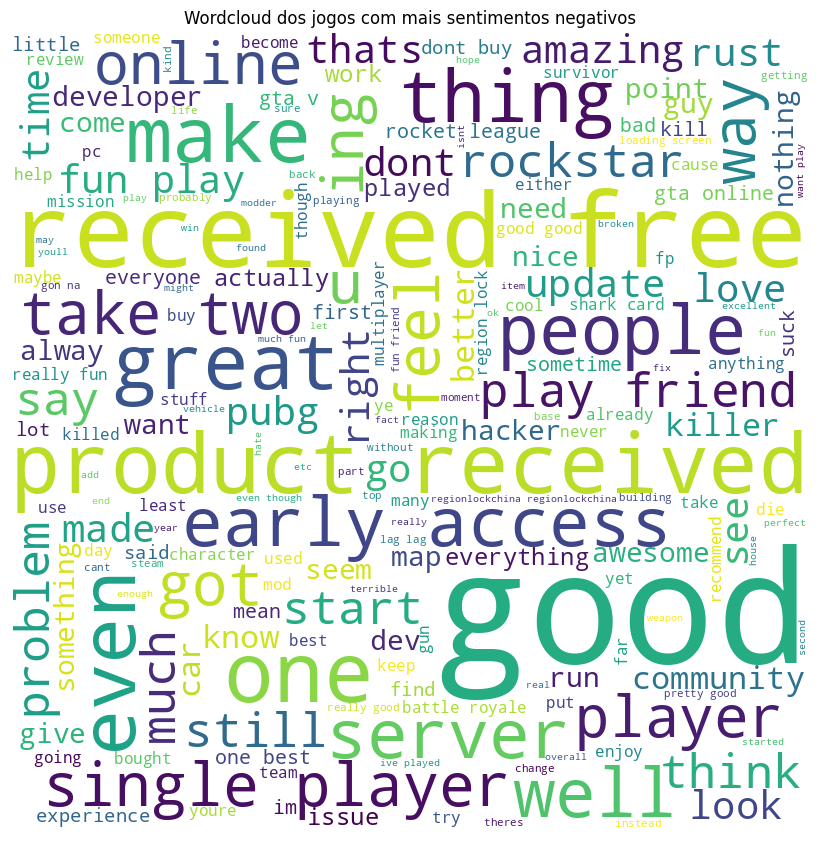

In [22]:
# wordcloud dos jogos com mais sentimentos negativos.
top_neg = df_neg.nlargest(5, 'count')
negative_games = top_neg['title'].tolist()
negative_reviews = df[df['title'].isin(negative_games)]['summary'].tolist()
create_wordcloud(negative_reviews, "Wordcloud dos jogos com mais sentimentos negativos")

Façamos algumas análises sobre os jogos:

* Análise de correlação, vendo a correlação entre o sentimento médio da review e a recomendação feita pelo usuário.
* Análise temporal, buscando os jogos que tiveram evolução no sentimento das reviews ao longo do tempo (análise nos jogos com maiores reviews positivos e negativos).
* Correlação entre total de horas, sentimento, recomendação e se o jogo estava em early access.

In [23]:
# Análise de correlação.
correlacao = df["ave_sentiment"].corr(df["recommendation"])
print("Correlação entre ave_sentiment e recommendation: ", correlacao)

Correlação entre ave_sentiment e recommendation:  0.3974367461777818


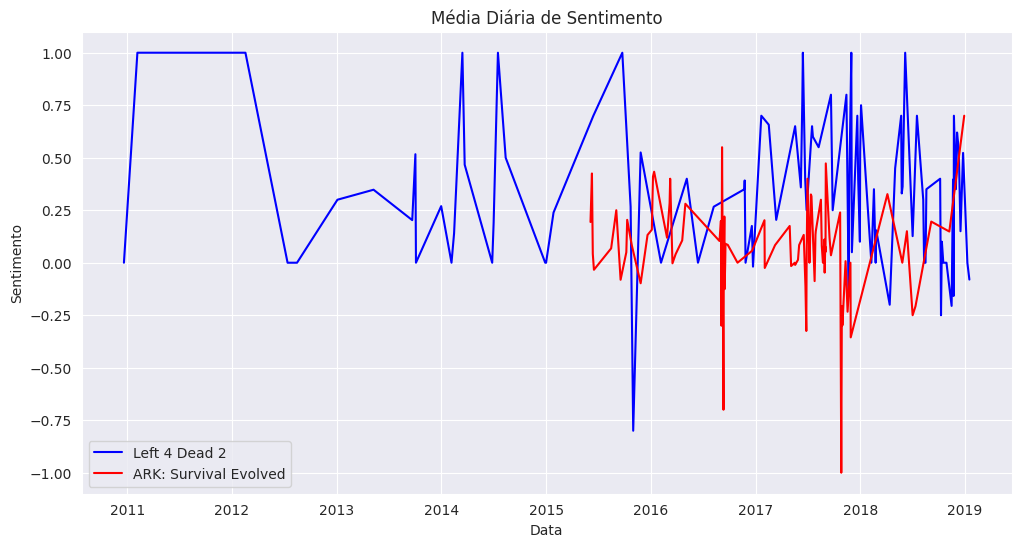

In [24]:
# Análise temporal.
import seaborn as sns

# Identificando o jogo com as reviews mais positivas.
most_positive_game = df.groupby(['title'])['sentiment'].mean().sort_values(ascending=False).reset_index().iloc[0]['title']

# Identificando o jogo com as reviews mais negativas.
most_negative_game = df.groupby(['title'])['sentiment'].mean().sort_values().reset_index().iloc[0]['title']

# Selecionando apenas as reviews dos jogos mais positivos e mais negativos.
most_positive_reviews = df[df['title'] == most_positive_game].copy()
most_negative_reviews = df[df['title'] == most_negative_game].copy()

# Criando coluna com a data da review.
most_positive_reviews['date_posted'] = pd.to_datetime(most_positive_reviews['date_posted'])
most_negative_reviews['date_posted'] = pd.to_datetime(most_negative_reviews['date_posted'])

# Calculando a média diária de sentimento para cada jogo.
most_positive_daily_sentiment = most_positive_reviews.groupby(['date_posted'])['sentiment'].mean()
most_negative_daily_sentiment = most_negative_reviews.groupby(['date_posted'])['sentiment'].mean()

# Plotando o gráfico.
sns.set_style("darkgrid")
plt.figure(figsize=(12,6))
plt.plot(most_positive_daily_sentiment.index, most_positive_daily_sentiment.values, color='blue')
plt.plot(most_negative_daily_sentiment.index, most_negative_daily_sentiment.values, color='red')
plt.legend([most_positive_game, most_negative_game])
plt.title('Média Diária de Sentimento')
plt.xlabel('Data')
plt.ylabel('Sentimento')
plt.show()

<Axes: >

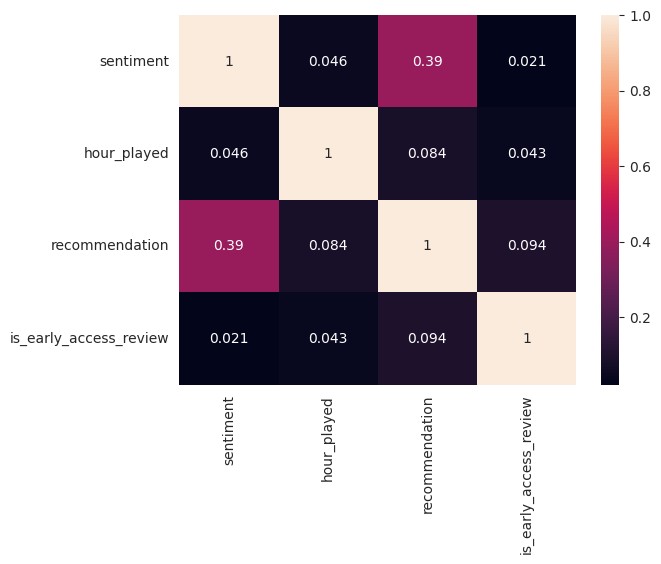

In [25]:
# Criando o heatmap para correlação entre total_hours, recommendation e is_early_access_review.
sns.heatmap(df[['sentiment', 'hour_played', 'recommendation', 'is_early_access_review']].corr(), annot=True)

#Modelagem de tópicos

Com a modelagem de tópicos, podemos coletar o feedback dos jogadores para cada jogo, de forma a mostrar para os desenvolvedores os pontos mais positivos e negativos de acordo com os reviews. Façamos isso utilizando LDA.

In [26]:
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel


# agrupa os resumos por jogo.
df_grouped = df.groupby('title')['summary'].apply(list).reset_index(name='summaries')

# cria um dicionário a partir dos resumos.
dictionary = corpora.Dictionary(df_grouped['summaries'])

# Transforma os resumos em um corpus.
corpus = [dictionary.doc2bow(summary) for summary in df_grouped['summaries']]

# Treina o modelo de LDA com o corpus.
num_topics = 5 # define o número de tópicos desejados.
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10)

In [27]:
df_games = df.groupby('title').agg({'sentiment': 'mean', 'hour_played': 'sum', 'new_review': 'count'}).reset_index()
df_games = df_games.rename(columns={'sentiment': 'average_sentiment', 'hour_played': 'total_hours_played', 'new_review': 'review_count'})


# cria uma lista vazia para armazenar os tópicos de cada jogo.
topics_list = []

# itera sobre os jogos do dataframe agrupado.
for index, row in df_grouped.iterrows():
    
    # transforma o resumo em um bag-of-words.
    summary_bow = dictionary.doc2bow(row['summaries'])
    
    # atribui os tópicos ao resumo.
    topic_scores = lda_model[summary_bow]
    
    # ordena os tópicos por ordem decrescente de peso.
    sorted_topics = sorted(topic_scores, key=lambda x: x[1], reverse=True)
    
    # armazena apenas o tópico mais relevante.
    top_topic = sorted_topics[0][0]
    
    # adiciona o tópico à lista de tópicos.
    topics_list.append(lda_model.show_topic(top_topic, topn=5))

# adiciona a lista de tópicos como uma nova coluna do dataframe.
df_games['topics'] = topics_list

df_games

,title,average_sentiment,total_hours_played,review_count,topics
0,ARK: Survival Evolved,0.073453,90563,110,"[(good, 0.00020408431), (nice, 0.000102513004)..."
1,ASTRONEER,0.297847,77105,1607,"[(good, 0.0007402248), (great, 0.00036254484),..."
2,Dead by Daylight,0.221248,3588687,13281,"[(good, 0.018409414), (, 0.010947411), (nice, ..."
3,Don't Starve Together,0.306183,18985,104,"[(good, 0.018409414), (, 0.010947411), (nice, ..."
4,Euro Truck Simulator 2,0.332831,60221,299,"[(good, 0.018409414), (, 0.010947411), (nice, ..."
5,Factorio,0.217056,37036,100,"[(good, 0.0007402248), (great, 0.00036254484),..."
6,Garry's Mod,0.291396,158757,122,"[(good, 0.011665996), (great, 0.0043205917), (..."
7,Grand Theft Auto V,0.214068,17488035,59410,"[(good, 0.018731853), (nice, 0.007570477), (, ..."
8,Human: Fall Flat,0.302769,1618,109,"[(good, 0.018731853), (nice, 0.007570477), (, ..."
9,Insurgency: Sandstorm,0.329425,6321,127,"[(good, 0.0007402248), (great, 0.00036254484),..."
